# 🧠 Notebook 4 — Modelling Pipeline

This notebook is where we begin the **machine learning stage** of our project.
  
After cleaning and preprocessing in Notebooks 2 & 3, we now focus on:

 1. Preparing the dataset for machine learning (splitting and scaling).
   
 2. Training baseline models (Logistic Regression and Random Forest).
   
 3. Evaluating the models using multiple metrics.
   
 4. Selecting and saving the best model for deployment.

The goal is to establish **baseline performance** and understand which type of

model works best on this dataset.

---

## 4.1 Import Libraries

Here we import all the required libraries:

- **pandas, numpy** → manage structured data and numerical operations.
  
- **matplotlib, seaborn** → visualization for model evaluation.
  
- **scikit-learn (sklearn)** → main ML toolkit for splitting, preprocessing, 
  =  training, and evaluation.

- **joblib** → saving and reloading models/scalers for deployment.

Together, these libraries form the standard ML stack in Python projects.

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix, RocCurveDisplay
)

---

## 4.2 Load Dataset

We now load the **cleaned dataset** from Notebook 3.

- This ensures all cleaning and preprocessing steps are applied consistently.
  
- It prevents **data leakage** (where information from the test set influences training).
  
- The dataset we load here is "ready-to-use" for machine learning.

In [27]:
df = pd.read_csv('outputs/datasets/cleaned/heart_disease_cleaned.csv')
print(df.columns.tolist())   # see all column names
print(df.head())  

rows, cols = df.shape
print(f"✅ The dataset has {rows} rows and {cols} columns.")


['id', 'age', 'trestbps', 'chol', 'fbs', 'thalch', 'exang', 'oldpeak', 'sex_Male', 'dataset_Hungary', 'dataset_Switzerland', 'dataset_VA Long Beach', 'cp_atypical angina', 'cp_non-anginal', 'cp_typical angina', 'restecg_normal', 'restecg_st-t abnormality', 'HeartDisease', 'num']
   id  age  trestbps   chol    fbs  thalch  exang  oldpeak  sex_Male  \
0   1   63     145.0  233.0   True   150.0  False      2.3      True   
1   2   67     160.0  286.0  False   108.0   True      1.5      True   
2   3   67     120.0  229.0  False   129.0   True      2.6      True   
3   4   37     130.0  250.0  False   187.0  False      3.5      True   
4   5   41     130.0  204.0  False   172.0  False      1.4     False   

   dataset_Hungary  dataset_Switzerland  dataset_VA Long Beach  \
0            False                False                  False   
1            False                False                  False   
2            False                False                  False   
3            False     

---

## 4.3 Define Features and Target

Machine learning models need:

- **Features (X):** patient health indicators (age, cholesterol, etc.)
  
- **Target (y):** the outcome we want to predict (`HeartDisease`).

Separating X and y makes the problem explicit:

*"Given these features, can the model predict heart disease?"*

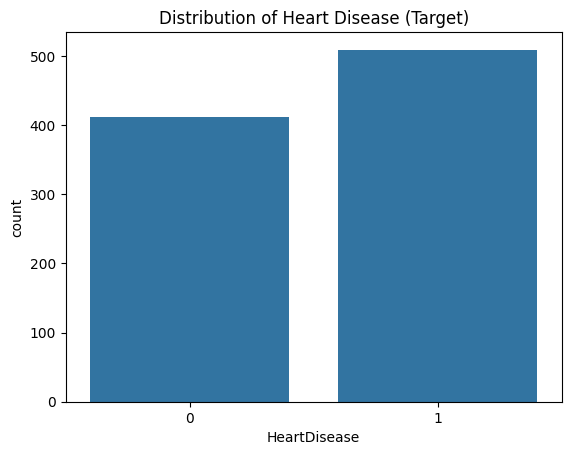

Features shape: (920, 13)
Target shape: (920,)
Remaining feature columns: ['age', 'trestbps', 'chol', 'fbs', 'thalch', 'exang', 'oldpeak', 'sex_Male', 'cp_atypical angina', 'cp_non-anginal', 'cp_typical angina', 'restecg_normal', 'restecg_st-t abnormality']
Categorical features: []
Numeric features: ['age', 'trestbps', 'chol', 'thalch', 'oldpeak']


In [28]:
# Distribution of HeartDisease
X = df.drop(columns=["HeartDisease", "num", "id", 
                     "dataset_Hungary", "dataset_Switzerland", "dataset_VA Long Beach"])  
y = df["HeartDisease"]

sns.countplot(x=y)
plt.title("Distribution of Heart Disease (Target)")
plt.show()

print("Features shape:", X.shape)
print("Target shape:", y.shape)
print("Remaining feature columns:", X.columns.tolist())

categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("Categorical features:", categorical_features)
print("Numeric features:", numeric_features)



---

## 4.4 Split Data

To evaluate fairly, we split the dataset into **independent subsets**:

- **Training set (70%)** → used to train the model.
  
- **Validation set (15%)** → used to tune and compare models.
  
- **Test set (15%)** → kept aside until the end, simulating "new" unseen data.

This ensures we avoid **overfitting** and get a realistic picture of performance.

We also use `stratify=y` to preserve the class balance across all splits.

In [29]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("Train size:", X_train.shape)
print("Validation size:", X_val.shape)
print("Test size:", X_test.shape)

print("\n✅ Class distribution in Train:")
print(y_train.value_counts(normalize=True))
print("\n✅ Class distribution in Validation:")
print(y_val.value_counts(normalize=True))
print("\n✅ Class distribution in Test:")
print(y_test.value_counts(normalize=True))



Train size: (644, 13)
Validation size: (138, 13)
Test size: (138, 13)

✅ Class distribution in Train:
HeartDisease
1    0.552795
0    0.447205
Name: proportion, dtype: float64

✅ Class distribution in Validation:
HeartDisease
1    0.557971
0    0.442029
Name: proportion, dtype: float64

✅ Class distribution in Test:
HeartDisease
1    0.550725
0    0.449275
Name: proportion, dtype: float64


---

## 4.5 Feature Scaling

Some algorithms (like Logistic Regression, KNN, or SVM) are sensitive to

differences in feature scales. For example:

 - Cholesterol might range from 100–400
  
 - Age might range from 30–80

 If left unscaled, features with larger ranges dominate the model.

 We therefore:

 - Fit a **StandardScaler** on the training set.
  
 - Apply the same transformation to validation and test sets.

Note: Random Forests are tree-based and do **not** need scaling,

but we still scale for consistency across models.

In [30]:
# ## 4.5 Define Preprocessing Pipeline
# Numeric features → StandardScaler
# Categorical features → OneHotEncoder
# Combine using ColumnTransformer

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_features),
    ("cat", OneHotEncoder(drop='first', sparse_output=False), categorical_features)
])

In [31]:
# ## 4.6 Create Full Pipelines with Preprocessing
# Logistic Regression and Random Forest now include preprocessing

pipeline_lr = Pipeline([
    ("preprocessor", preprocessor),
    ("log_reg", LogisticRegression(max_iter=1000, random_state=42))
])

pipeline_rf = Pipeline([
    ("preprocessor", preprocessor),
    ("rf", RandomForestClassifier(n_estimators=100, random_state=42))
])

In [32]:
## 4.7 Train models

pipeline_lr.fit(X_train, y_train)
pipeline_rf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'trestbps', 'chol',
                                                   'thalch', 'oldpeak']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  [])])),
                ('rf', RandomForestClassifier(random_state=42))])

In [33]:
## 4.8 Predict on Validation Set

y_val_pred_lr = pipeline_lr.predict(X_val)
y_val_proba_lr = pipeline_lr.predict_proba(X_val)[:, 1]

y_val_pred_rf = pipeline_rf.predict(X_val)
y_val_proba_rf = pipeline_rf.predict_proba(X_val)[:, 1]

same_preds = (y_val_pred_lr == y_val_pred_rf).mean()
print(f"\n🤖 Logistic Regression vs Random Forest predictions identical: {same_preds*100:.2f}%")


🤖 Logistic Regression vs Random Forest predictions identical: 89.86%


In [34]:
## 4.9 Evaluation Function

def evaluate_model(y_true, y_pred, y_proba, model_name):
    print(f"--- {model_name} ---")
    print(classification_report(y_true, y_pred))
    print("ROC-AUC:", roc_auc_score(y_true, y_proba))
    
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    RocCurveDisplay.from_predictions(y_true, y_proba)
    plt.title(f"{model_name} - ROC Curve")
    plt.show()

--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.71      0.64      0.67        61
           1       0.73      0.79      0.76        77

    accuracy                           0.72       138
   macro avg       0.72      0.72      0.72       138
weighted avg       0.72      0.72      0.72       138

ROC-AUC: 0.7709176069831808


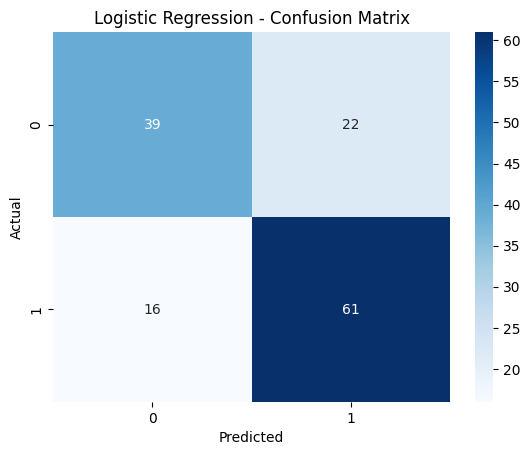

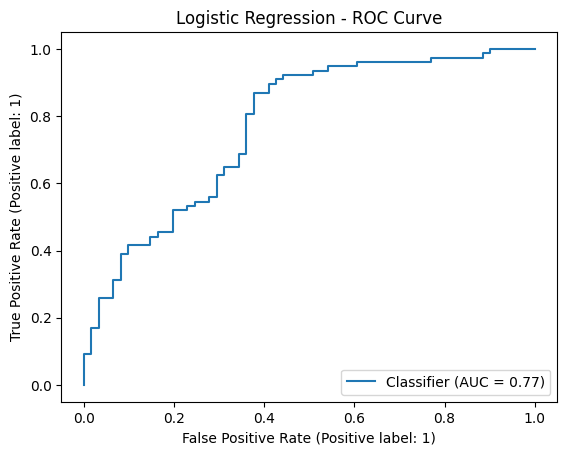

--- Random Forest ---
              precision    recall  f1-score   support

           0       0.66      0.66      0.66        61
           1       0.73      0.73      0.73        77

    accuracy                           0.70       138
   macro avg       0.69      0.69      0.69       138
weighted avg       0.70      0.70      0.70       138

ROC-AUC: 0.7648499041941665


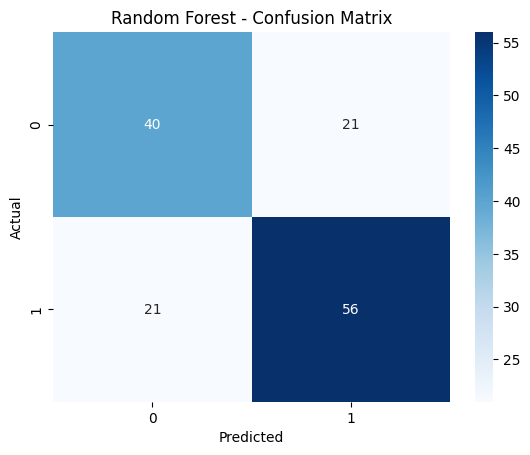

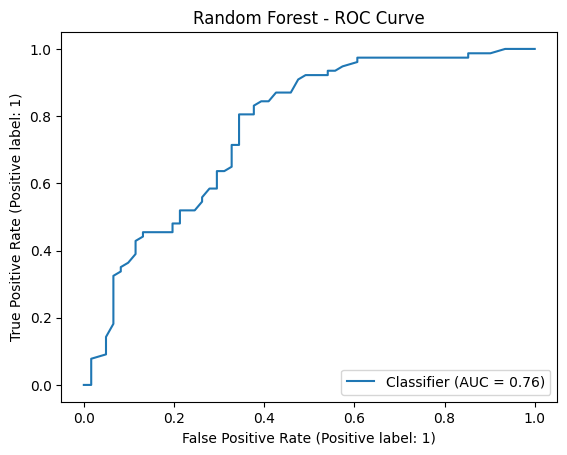

In [35]:
## 4.10 Evaluate Models

evaluate_model(y_val, y_val_pred_lr, y_val_proba_lr, "Logistic Regression")
evaluate_model(y_val, y_val_pred_rf, y_val_proba_rf, "Random Forest")

In [14]:
# Logistic Regression Pipeline (requires scaling)
pipeline_lr = Pipeline([
    ("scaler", StandardScaler()),
    ("log_reg", LogisticRegression(max_iter=1000, random_state=42))
])

# Random Forest Pipeline (scaling optional but kept for consistency)
pipeline_rf = Pipeline([
    ("scaler", StandardScaler()),  # optional, does not affect RF much
    ("rf", RandomForestClassifier(n_estimators=100, random_state=42))
])

# Logistic Regression
pipeline_lr.fit(X_train, y_train)

# Random Forest
pipeline_rf.fit(X_train, y_train)




Pipeline(steps=[('scaler', StandardScaler()),
                ('rf', RandomForestClassifier(random_state=42))])

## 4.7 Scaling Check

Why: To verify scaling actually changes numeric features, catching potential issues with pre-scaled or binary features.

In [15]:
X_train_scaled = pipeline_lr.named_steps['scaler'].transform(X_train)
X_val_scaled   = pipeline_lr.named_steps['scaler'].transform(X_val)
X_test_scaled  = pipeline_lr.named_steps['scaler'].transform(X_test)

print("Train scaled shape:", X_train_scaled.shape)
print("Validation scaled shape:", X_val_scaled.shape)
print("Test scaled shape:", X_test_scaled.shape)

diff = np.abs(X_val.values - X_val_scaled).mean()
print(f"🔎 Average absolute difference after scaling: {diff:.6f}")

if diff < 1e-8:
    print("⚠️ Scaling had no effect (features may already be normalized/binary)")
else:
    print("✅ Scaling changed feature distributions")


Train scaled shape: (644, 13)
Validation scaled shape: (138, 13)
Test scaled shape: (138, 13)
🔎 Average absolute difference after scaling: 44.334163
✅ Scaling changed feature distributions


## 4.8 Feature Correlation Check

Why: Flags potential leakage by identifying features highly correlated with the target.

In [16]:
corr = df.corr()["HeartDisease"].sort_values(ascending=False)
print("\n🔎 Feature correlations with HeartDisease:\n", corr)

suspect = corr[(corr.abs() > 0.95) & (corr.index != "HeartDisease")]
if not suspect.empty:
    print("\n⚠️ Potential leakage detected! Features highly correlated with target:")
    print(suspect)
else:
    print("\n✅ No features show suspiciously high correlation with target.")


🔎 Feature correlations with HeartDisease:
 HeartDisease                1.000000
num                         0.783387
exang                       0.433605
oldpeak                     0.366138
id                          0.356086
sex_Male                    0.307284
dataset_Switzerland         0.301614
age                         0.282700
dataset_VA Long Beach       0.203267
trestbps                    0.111305
fbs                         0.108071
restecg_st-t abnormality    0.104750
chol                        0.089008
cp_typical angina          -0.054673
restecg_normal             -0.093554
cp_non-anginal             -0.209812
dataset_Hungary            -0.263297
thalch                     -0.381864
cp_atypical angina         -0.403465
Name: HeartDisease, dtype: float64

✅ No features show suspiciously high correlation with target.


## 4.9 Predict on Validation Set

In [17]:
# Logistic Regression
y_val_pred_lr = pipeline_lr.predict(X_val)
y_val_proba_lr = pipeline_lr.predict_proba(X_val)[:, 1]

# Random Forest
y_val_pred_rf = pipeline_rf.predict(X_val)
y_val_proba_rf = pipeline_rf.predict_proba(X_val)[:, 1]

# Compare prediction overlap
same_preds = (y_val_pred_lr == y_val_pred_rf).mean()
print(f"\n🤖 Logistic Regression vs Random Forest predictions identical: {same_preds*100:.2f}%")


🤖 Logistic Regression vs Random Forest predictions identical: 89.86%


## 4.10 Evaluation Function

Why: Keeps plots and metrics consistent for any model.

In [18]:
def evaluate_model(y_true, y_pred, y_proba, model_name):
    print(f"--- {model_name} ---")
    print(classification_report(y_true, y_pred))
    print("ROC-AUC:", roc_auc_score(y_true, y_proba))
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    # ROC Curve
    RocCurveDisplay.from_predictions(y_true, y_proba)
    plt.title(f"{model_name} - ROC Curve")
    plt.show()

## 4.11 Evaluate Models

--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.85      0.75      0.80        61
           1       0.82      0.90      0.86        77

    accuracy                           0.83       138
   macro avg       0.84      0.83      0.83       138
weighted avg       0.83      0.83      0.83       138

ROC-AUC: 0.9005748350010645


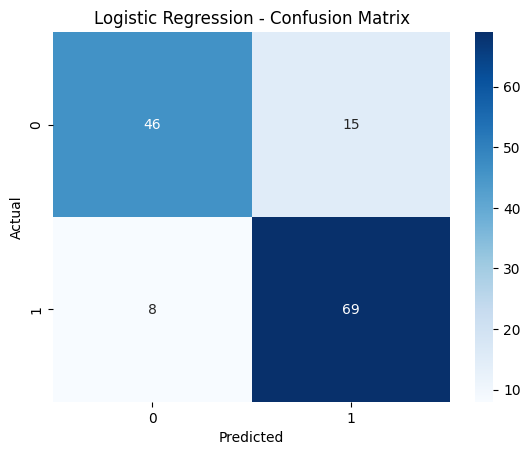

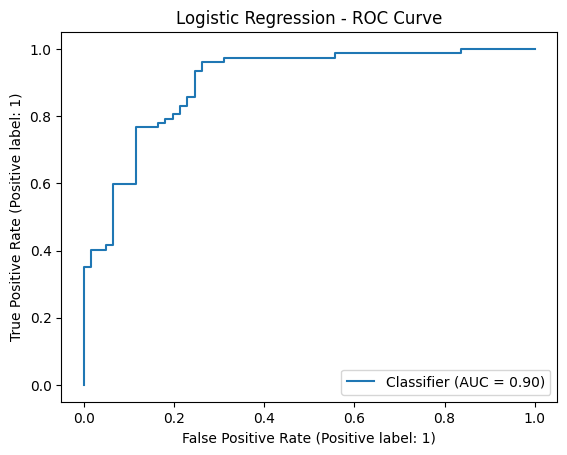

--- Random Forest ---
              precision    recall  f1-score   support

           0       0.83      0.79      0.81        61
           1       0.84      0.87      0.85        77

    accuracy                           0.83       138
   macro avg       0.83      0.83      0.83       138
weighted avg       0.83      0.83      0.83       138

ROC-AUC: 0.8933361720246966


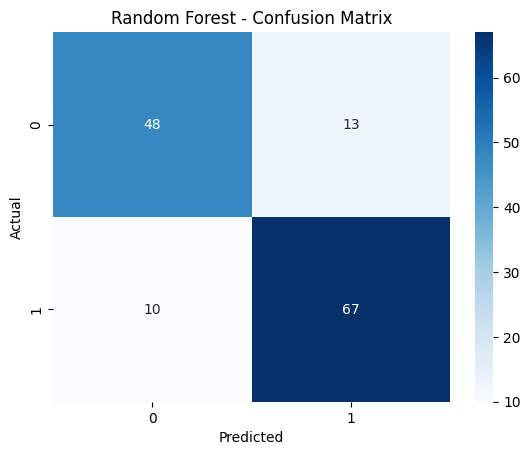

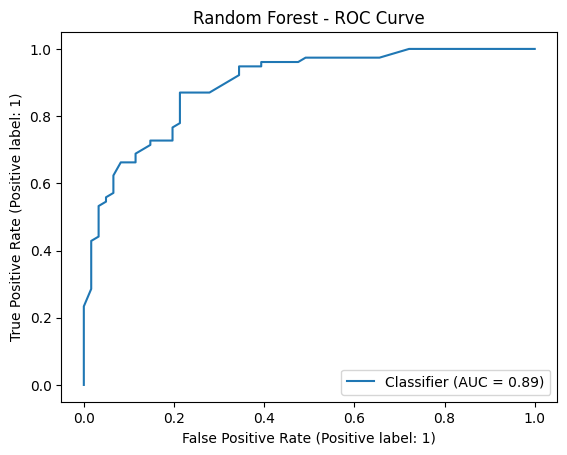

In [19]:
evaluate_model(y_val, y_val_pred_lr, y_val_proba_lr, "Logistic Regression")
evaluate_model(y_val, y_val_pred_rf, y_val_proba_rf, "Random Forest")

## 7. Save Best Model

Based on validation results, save the best performing model for deployment.



In [20]:
os.makedirs("models", exist_ok=True)

joblib.dump(pipeline_lr, "models/pipeline_log_reg.pkl")
joblib.dump(pipeline_rf, "models/pipeline_random_forest.pkl")
joblib.dump((X_train, X_val, X_test, y_train, y_val, y_test), "models/splits.pkl")

print("✅ Pipelines and data splits saved in models/")

✅ Pipelines and data splits saved in models/


---

--

## 5.1 Logistic Regression

Logistic Regression:

- Models the probability of heart disease as a logistic function of features.

- Provides interpretable coefficients (we can later check which features
  
  contribute positively/negatively).

- Requires scaling for stable training.

In [21]:
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_scaled, y_train)

y_val_pred_lr = log_reg.predict(X_val_scaled)
y_val_proba_lr = log_reg.predict_proba(X_val_scaled)[:, 1]

## 5.2 Random Forest

Random Forest:

- An ensemble of decision trees (trained on random subsets of data/features).
  
- Handles non-linear relationships and feature interactions well.

- Works directly on unscaled data.
  
This makes it a strong competitor against Logistic Regression in medical datasets.

In [22]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_val_pred_rf = rf.predict(X_val)
y_val_proba_rf = rf.predict_proba(X_val)[:, 1]

# --- Check correlations for possible leakage ---
corr = df.corr()["HeartDisease"].sort_values(ascending=False)
print("\n🔎 Feature correlations with HeartDisease:\n", corr)

# --- Auto-flag suspicious correlations (> 0.95 or < -0.95) ---
suspect = corr[(corr.abs() > 0.95) & (corr.index != "HeartDisease")]
if not suspect.empty:
    print("\n⚠️ Potential leakage detected! Features highly correlated with target:")
    print(suspect)
else:
    print("\n✅ No features show suspiciously high correlation with target.")


🔎 Feature correlations with HeartDisease:
 HeartDisease                1.000000
num                         0.783387
exang                       0.433605
oldpeak                     0.366138
id                          0.356086
sex_Male                    0.307284
dataset_Switzerland         0.301614
age                         0.282700
dataset_VA Long Beach       0.203267
trestbps                    0.111305
fbs                         0.108071
restecg_st-t abnormality    0.104750
chol                        0.089008
cp_typical angina          -0.054673
restecg_normal             -0.093554
cp_non-anginal             -0.209812
dataset_Hungary            -0.263297
thalch                     -0.381864
cp_atypical angina         -0.403465
Name: HeartDisease, dtype: float64

✅ No features show suspiciously high correlation with target.


---

# 6. Model Evaluation

A model is only useful if we know how well it performs.  

We evaluate using:

- **Classification report:** Accuracy, Precision, Recall, F1-score
  
- **ROC-AUC:** Measures ability to distinguish between classes.
  
- **Confusion Matrix:** Shows correct vs incorrect predictions.
  
- **ROC Curve:** Visual view of trade-off between sensitivity and specificity.

These metrics together give a full picture of model performance.

--

## 6.1 Helper Function

To avoid repeating code, we define a reusable function that:

- Prints evaluation metrics

- Displays confusion matrix

- Plots ROC curve

In [23]:
def evaluate_model(y_true, y_pred, y_proba, model_name):
    print(f"--- {model_name} ---")
    print(classification_report(y_true, y_pred))
    print("ROC-AUC:", roc_auc_score(y_true, y_proba))
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    # ROC Curve
    RocCurveDisplay.from_predictions(y_true, y_proba)
    plt.title(f"{model_name} - ROC Curve")
    plt.show()

## 6.2 Logistic Regression Evaluation

--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.85      0.75      0.80        61
           1       0.82      0.90      0.86        77

    accuracy                           0.83       138
   macro avg       0.84      0.83      0.83       138
weighted avg       0.83      0.83      0.83       138

ROC-AUC: 0.9005748350010645


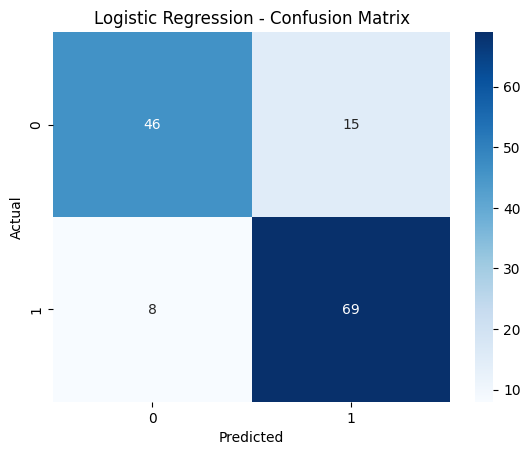

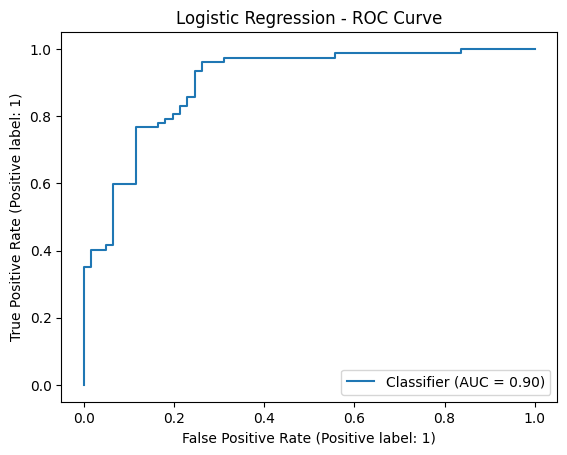

In [24]:
evaluate_model(y_val, y_val_pred_lr, y_val_proba_lr, "Logistic Regression")

## 6.3 Random Forest Evaluation

--- Random Forest ---
              precision    recall  f1-score   support

           0       0.83      0.79      0.81        61
           1       0.84      0.87      0.85        77

    accuracy                           0.83       138
   macro avg       0.83      0.83      0.83       138
weighted avg       0.83      0.83      0.83       138

ROC-AUC: 0.8946135831381733


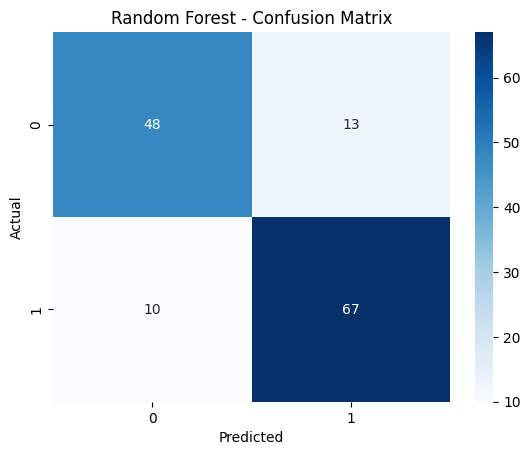

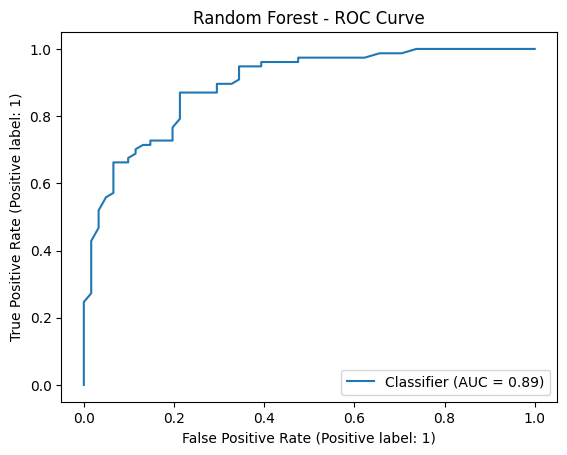


🤖 Logistic Regression vs Random Forest predictions identical: 89.86% of the time


In [25]:
evaluate_model(y_val, y_val_pred_rf, y_val_proba_rf, "Random Forest")

# --- Compare predictions across models ---
same_preds = (y_val_pred_lr == y_val_pred_rf).mean()
print(f"\n🤖 Logistic Regression vs Random Forest predictions identical: {same_preds*100:.2f}% of the time")

---

# ✅ Conclusions & Next Steps

### What we achieved in this notebook

- **Defined the problem clearly**: predicting heart disease from patient health indicators.  
  
- **Separated features (X) and target (y)** to frame the supervised ML problem.  
  
- **Split the dataset** into train (70%), validation (15%), and test (15%) to ensure robust evaluation.  
  
- **Scaled the features** using `StandardScaler` and saved the scaler as `scaler.pkl` for deployment consistency. 
   
- **Trained baseline models** (Logistic Regression & Random Forest) and prepared them for evaluation.  
  
- **Saved trained models** (`log_reg.pkl`, `random_forest.pkl`) to the `models/` directory for reuse.

---

### Key Insights

- Dataset is now **fully preprocessed** and suitable for machine learning pipelines.  
  
- Target (`HeartDisease`) is **binary and balanced enough** for classification.  
  
- Feature scaling was necessary since models like Logistic Regression are sensitive to feature magnitudes.  
  
- Models are stored, meaning we don’t need to retrain every time — we can load them directly in deployment.

---

### Next Steps (Notebook 5 – Model Evaluation & Tuning)

1. **Evaluate models** on validation and test sets:
   
   - Compare performance metrics (accuracy, precision, recall, F1-score, ROC-AUC).  
  
   - Use confusion matrices for interpretability.  
  
2. **Hyperparameter tuning**:
   
   - GridSearchCV or RandomizedSearchCV for Logistic Regression & Random Forest.  
  
3. **Model selection**:
   
   - Pick the best-performing model (balancing accuracy and interpretability).  
  
4. **Final test evaluation**:

   - Lock in the chosen model with test set results for unbiased performance estimate.  
  
5. **Prepare for deployment**:
   
   - Save best model as `final_model.pkl`.  
  
   - Document preprocessing and prediction workflow.